In [4]:
%matplotlib inline
%load_ext rpy2.ipython

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Archimedes procedure for porous material density determination

Experimental procedure is as follow, for further detail refer to standard ASTM B962. 

1. Measure temperature of liquid to determine its ($\rho_{\text{water}}$) and find object theoretical full density ( $\rho_{\text{solid}}$ ) from datasheet
2. Measure mass of sample(s) in air(A)
3. Impregnate the sample(s) with oil
4. Measure mass of sample(s) saturated with oil in air (B)
5. Measure mass of sample(s) saturated with oil in water (F)


\begin{equation}
    \text{Green Density}, D_g = \frac{A \rho_{water}}{B-F}
\end{equation}

\begin{equation}
    \text{true density}, \pi_d = \frac{ D_g}{\rho_{\text{solid}}} * 100
\end{equation}

Parts using two powder type are made. Parts labeled bimodal should have a higher density then parts labelled unimodal.

## Load Data from excel sheet

In [5]:
data = pd.read_excel('./data/green_sample_benchmark.xls', sheet_name = 'oil', index_col= [0,1])
oil_density = pd.read_excel('./data/green_sample_benchmark.xls', sheet_name = 'oil_param', index_col= 0)

## Display first few row of excel sheet

In [6]:
data.head()

powder type  dry weight  coated weight  wet coated  exp  operator
batch ID                                                                  
2     1      Bimodal     15.4440        16.6229     13.1582    1         1
      5      Bimodal     15.8476        17.0214     13.5416    1         1
1     2     Unimodal     15.2508        16.6189     13.0623    1         1
      4     Unimodal     15.3899        16.6853     13.1755    1         1
4     1     Unimodal     14.8467        16.4155     12.7117    2         1

## Carrier fluid density

Density of the carrier fluid ($\rho_{\text{water}}$) is necessary for density calculation. Since the density of the fluid fluctuate depending on temperature and temperature varies from experiment to experiment, it is recorded for each experiment. For experiment 2 it was recorded at the beginning and at the end.

In [7]:
oil_density.head()

,oil density,water density
exp,,
1,0.914,0.99730
2,0.914,0.99780
3,0.914,0.99798
3,0.914,0.99787


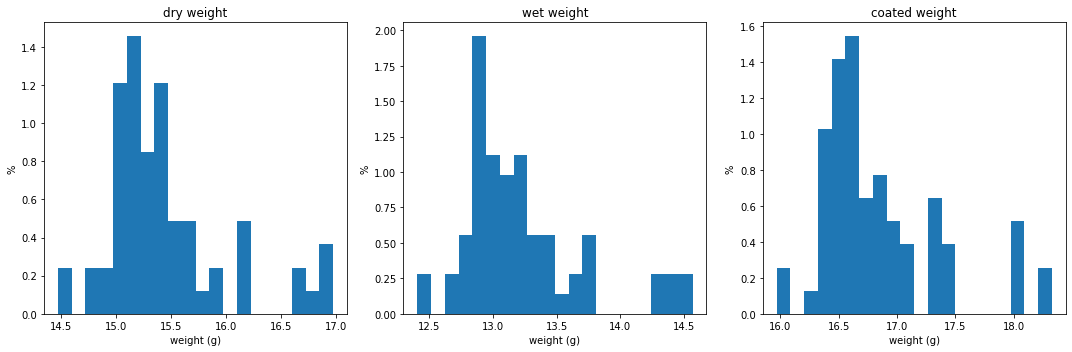

In [8]:
def plot_hist(data, b):
    fig, axes = plt.subplots(1,3, figsize = (15,5))
    axes[0].hist(data['dry weight'], bins = b, density = True)
    axes[0].set_title('dry weight')
    axes[0].set_xlabel('weight (g)')
    axes[0].set_ylabel('%')

    axes[1].hist(data['wet coated'], bins = b, density = True)
    axes[1].set_title('wet weight')
    axes[1].set_xlabel('weight (g)')
    axes[1].set_ylabel('%')

    axes[2].hist(data['coated weight'], bins = b, density = True)
    axes[2].set_title('coated weight')
    axes[2].set_xlabel('weight (g)')
    axes[2].set_ylabel('%')
    
    plt.tight_layout()
    plt.show()

plot_hist(data, 20)

## Compute density
Each sample was measured 3 times at each stage. Since we are only interested in the uncertainty in the true density ($\pi_d$), a cartesian product of each measured weights (dry, wet and coated) and liquid density is done for each sample in order to compute true density.

In [9]:
density_df = pd.DataFrame(columns = ['batch', 'id', 'density', 'operator', 'powder'])

# density of stainless steel 316L (g/cc) taken from data sheet
den_ss316 = 8.0

unique_id = 0

# iterate over each sample to do cartesian product
for idx in data.index.unique():
    sample = data.loc[idx]

    op = int(np.unique(sample['operator']).squeeze())
    powder = str(np.unique(sample['powder type']).squeeze())
    batch = idx[0]

    d_weight = sample['dry weight'].to_numpy()
    wc_weight = sample['wet coated'].to_numpy()
    c_weight = sample['coated weight'].to_numpy()

    exp_num = sample['exp']
    # density of liquid taken from datasheet
    water_den = np.unique(oil_density.loc[exp_num]['water density'].to_numpy())

    prod = product(d_weight, wc_weight, c_weight, water_den)
    
    # cartesian product
    for d_w, wc_w, c_w, water_d in prod:
        #compute true density refer to equation on top
        den = d_w/(c_w - wc_w)*water_d/den_ss316*100
        new_entry = {
            'batch' : batch,
            'id' : unique_id,
            'density' : float(den.squeeze()),
            'operator' : op,
            'powder' : powder
        }

        density_df = density_df.append(new_entry, ignore_index = True)
    
    unique_id += 1

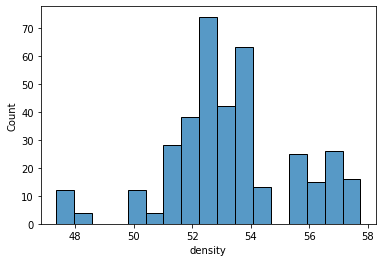

In [10]:
ax = sns.histplot(density_df['density'])

In [11]:
%%R -i density_df

library(lme4)
library(lmerTest)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [12]:
%%R -i density_df

fixed_lm <- lm(density ~ factor(operator) + factor(powder), data = density_df)
summary(fixed_lm)


Call:
lm(formula = density ~ factor(operator) + factor(powder), data = density_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.2071 -1.0763  0.1402  1.3582  3.3061 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             53.6550     0.1794 299.047  < 2e-16 ***
factor(operator)2        1.1937     0.1919   6.219 1.35e-09 ***
factor(powder)Unimodal  -2.2987     0.1838 -12.504  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.77 on 369 degrees of freedom
Multiple R-squared:  0.3517,	Adjusted R-squared:  0.3482 
F-statistic: 100.1 on 2 and 369 DF,  p-value: < 2.2e-16



In [13]:
%%R
anova(fixed_lm)

Analysis of Variance Table

Response: density
                  Df  Sum Sq Mean Sq F value    Pr(>F)    
factor(operator)   1  137.43  137.43  43.851 1.254e-10 ***
factor(powder)     1  490.00  490.00 156.349 < 2.2e-16 ***
Residuals        369 1156.45    3.13                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


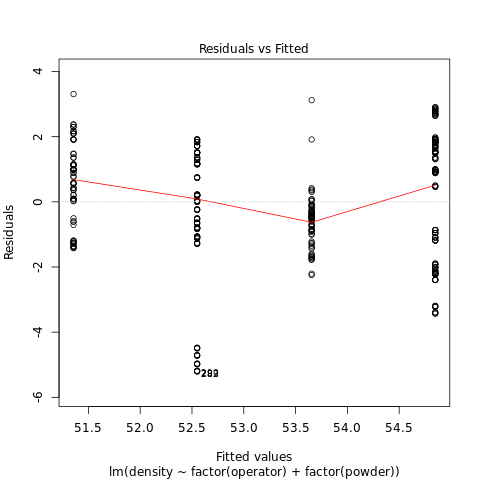

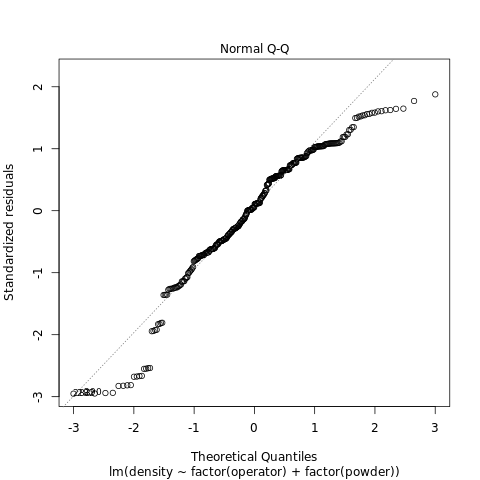

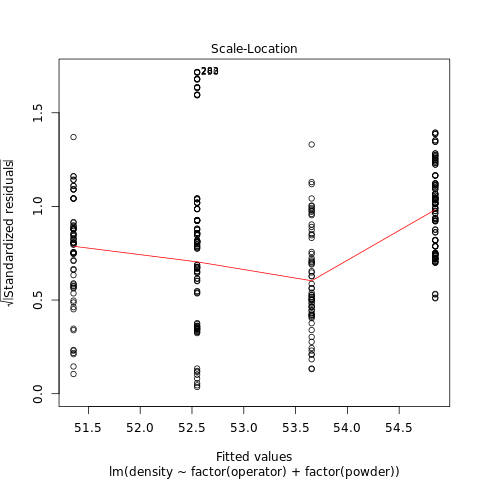

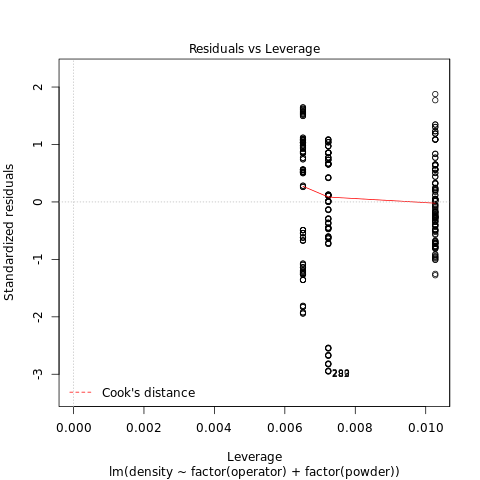

In [14]:
%%R
plot(fixed_lm)

In [15]:
%%R

mixed_lm_1 <- lmer(density ~ factor(operator) + factor(powder) + (1|id), data = density_df)
summary(mixed_lm_1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: density ~ factor(operator) + factor(powder) + (1 | id)
   Data: density_df

REML criterion at convergence: 490.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.98426 -0.58314  0.03018  0.59043  2.98571 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 3.0877   1.7572  
 Residual             0.1345   0.3667  
Number of obs: 372, groups:  id, 35

Fixed effects:
                       Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)             53.9460     0.4955 32.0110 108.875   <2e-16 ***
factor(operator)2        0.7629     0.6026 31.7521   1.266   0.2147    
factor(powder)Unimodal  -1.9990     0.5971 31.8389  -3.348   0.0021 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) fct()2
fctr(prtr)2 -0.544       
fctr(pwdr)U -0.603  0.033


In [16]:
%%R
anova(mixed_lm_1)

Type III Analysis of Variance Table with Satterthwaite's method
                  Sum Sq Mean Sq NumDF  DenDF F value   Pr(>F)   
factor(operator) 0.21548 0.21548     1 31.752  1.6026 0.214744   
factor(powder)   1.50692 1.50692     1 31.839 11.2075 0.002104 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [17]:
%%R -i density_df

mixed_lm_2 <- lmer(density ~ factor(operator) + factor(powder) + (1|operator/id), data = density_df)
summary(mixed_lm_1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: density ~ factor(operator) + factor(powder) + (1 | id)
   Data: density_df

REML criterion at convergence: 490.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.98426 -0.58314  0.03018  0.59043  2.98571 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 3.0877   1.7572  
 Residual             0.1345   0.3667  
Number of obs: 372, groups:  id, 35

Fixed effects:
                       Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)             53.9460     0.4955 32.0110 108.875   <2e-16 ***
factor(operator)2        0.7629     0.6026 31.7521   1.266   0.2147    
factor(powder)Unimodal  -1.9990     0.5971 31.8389  -3.348   0.0021 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) fct()2
fctr(prtr)2 -0.544       
fctr(pwdr)U -0.603  0.033


In [18]:
%%R
anova(mixed_lm_2)

Type III Analysis of Variance Table with Satterthwaite's method
                 Sum Sq Mean Sq NumDF   DenDF F value   Pr(>F)   
factor(operator) 0.1070  0.1070     1 117.473  0.7958 0.374180   
factor(powder)   1.5067  1.5067     1  31.831 11.2057 0.002106 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [19]:
%%R -i density_df

mixed_lm_3 <- lmer(density ~ factor(operator) + factor(powder) + (1|batch), data = density_df)
summary(mixed_lm_3)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: density ~ factor(operator) + factor(powder) + (1 | batch)
   Data: density_df

REML criterion at convergence: 1221.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2254 -0.4374  0.1283  0.5502  2.7123 

Random effects:
 Groups   Name        Variance Std.Dev.
 batch    (Intercept) 2.426    1.557   
 Residual             1.441    1.200   
Number of obs: 372, groups:  batch, 9

Fixed effects:
                       Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)             54.2618     0.8094   6.9399  67.036 5.11e-11 ***
factor(operator)2        0.5474     0.1720 368.5303   3.183  0.00158 ** 
factor(powder)Unimodal  -1.8528     1.0790   6.7641  -1.717  0.13115    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) fct()2
fctr(prtr)2 -0.103       
fctr(pwdr)U -0.741 -0.011


In [20]:
%%R
compare_lm = anova(mixed_lm_1, mixed_lm_2, mixed_lm_3, fixed_lm)
compare_lm

R[write to console]: refitting model(s) with ML (instead of REML)

Data: density_df
Models:
fixed_lm: density ~ factor(operator) + factor(powder)
mixed_lm_1: density ~ factor(operator) + factor(powder) + (1 | id)
mixed_lm_3: density ~ factor(operator) + factor(powder) + (1 | batch)
mixed_lm_2: density ~ factor(operator) + factor(powder) + (1 | operator/id)
           Df     AIC     BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
fixed_lm    4 1485.62 1501.30 -738.81  1477.62                             
mixed_lm_1  5  500.98  520.57 -245.49   490.98 986.64      1     <2e-16 ***
mixed_lm_3  5 1232.13 1251.73 -611.07  1222.13   0.00      0          1    
mixed_lm_2  6  502.98  526.49 -245.49   490.98 731.16      1     <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
